In [ ]:
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 42.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [ ]:
import kagglehub

import imageio
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import os
import torch
import torchvision.transforms.v2 as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.nn.functional as F

import pytorch_lightning as pl
import torch.optim as optim
from torchmetrics.classification import MulticlassJaccardIndex

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping

from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_lightning import Trainer
import warnings

import cv2

In [ ]:
import kagglehub

path = kagglehub.dataset_download("kumaresanmanickavelu/lyft-udacity-challenge")

print("Path to dataset files:", path)

100%|██████████| 5.11G/5.11G [00:55<00:00, 99.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kumaresanmanickavelu/lyft-udacity-challenge/versions/1


# Data proccessing


In [ ]:
import os
for root, dirs, files in os.walk(path):
    level = root.replace(path, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")


1/
    dataB/
        dataB/
            CameraRGB/
            CameraSeg/
    datae/
        dataE/
            CameraRGB/
            CameraSeg/
    datad/
        dataD/
            CameraRGB/
            CameraSeg/
    dataa/
        dataA/
            CameraRGB/
            CameraSeg/
    dataD/
        dataD/
            CameraRGB/
            CameraSeg/
    dataE/
        dataE/
            CameraRGB/
            CameraSeg/
    datac/
        dataC/
            CameraRGB/
            CameraSeg/
    datab/
        dataB/
            CameraRGB/
            CameraSeg/
    dataA/
        dataA/
            CameraRGB/
            CameraSeg/
    dataC/
        dataC/
            CameraRGB/
            CameraSeg/


In [ ]:
image_path = [path+"/data"+i+"/"+"data"+i+"/CameraRGB/" for i in ['A', 'B', 'C', 'D', 'E']]
mask_path = [path+"/data"+i+"/"+"data"+i+"/CameraSeg/" for i in ['A', 'B', 'C', 'D', 'E']]

In [ ]:
def list_image_paths(directory_paths):
    image_paths = []
    for directory in range(len(directory_paths)):
        image_filenames = os.listdir(directory_paths[directory])
        for image_filename in image_filenames:
            image_paths.append(directory_paths[directory] + image_filename)
    return image_paths


In [ ]:
image_paths = sorted(list_image_paths(image_path))
mask_paths = sorted(list_image_paths(mask_path))


In [ ]:
import imageio
import random
import numpy as np
random_index = random.randint(0, len(mask_paths) - 1)

# Read the randomly selected mask image
mask_sample = imageio.imread(mask_paths[random_index])

# Check the result
print(f"Loaded mask from: {mask_paths[random_index]}")


# Check unique pixel values in the mask
unique_values = np.unique(mask_sample)
print(f"Unique pixel values in the mask: {unique_values}")

Loaded mask from: /root/.cache/kagglehub/datasets/kumaresanmanickavelu/lyft-udacity-challenge/versions/1/dataC/dataC/CameraSeg/03_00_004.png
Unique pixel values in the mask: [ 0  1  2  3  5  6  7  8  9 10 11 12]


<ipython-input-6-c23862405a1a>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask_sample = imageio.imread(mask_paths[random_index])


In [ ]:
from PIL import Image
import numpy as np
first_mask_path = mask_paths[0]

# Mở ảnh mask
mask = Image.open(first_mask_path)
mask.mode

'RGB'

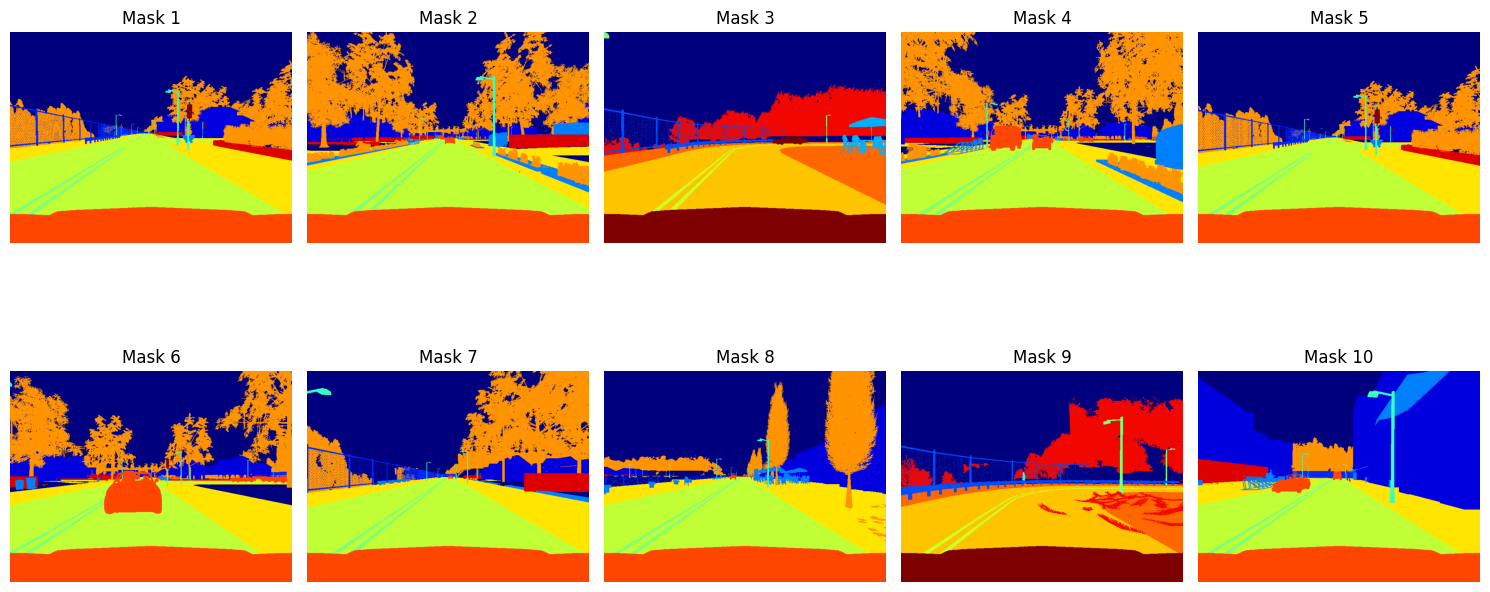

In [ ]:
import matplotlib.pyplot as plt

sample_paths = random.sample(mask_paths, 10)

# Hiển thị ảnh
plt.figure(figsize=(15, 8))
for i, path in enumerate(sample_paths):
    img = np.array(Image.open(path))  # convert to numpy
    if img.ndim == 3:
        img = img[:, :, 0]  # lấy kênh đầu nếu RGB
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='jet')
    plt.axis('off')
    plt.title(f"Mask {i+1}")
plt.tight_layout()
plt.show()

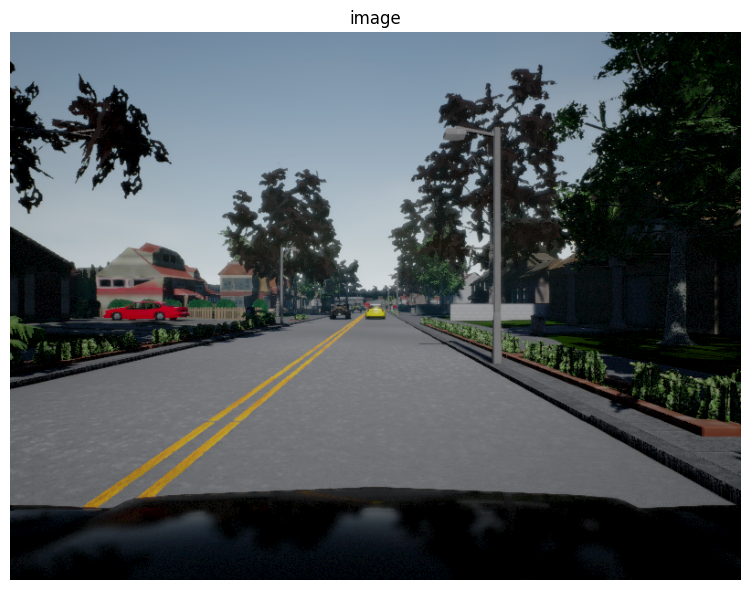

In [ ]:
image_path  = image_paths[100]
image = Image.open(image_path)

image  = np.array(image)
# Hiển thị từng lớp
plt.figure(figsize=(18, 6))

plt.imshow(image, cmap='gray')
plt.title(f"image")
plt.axis('off')
plt.tight_layout()
plt.show()

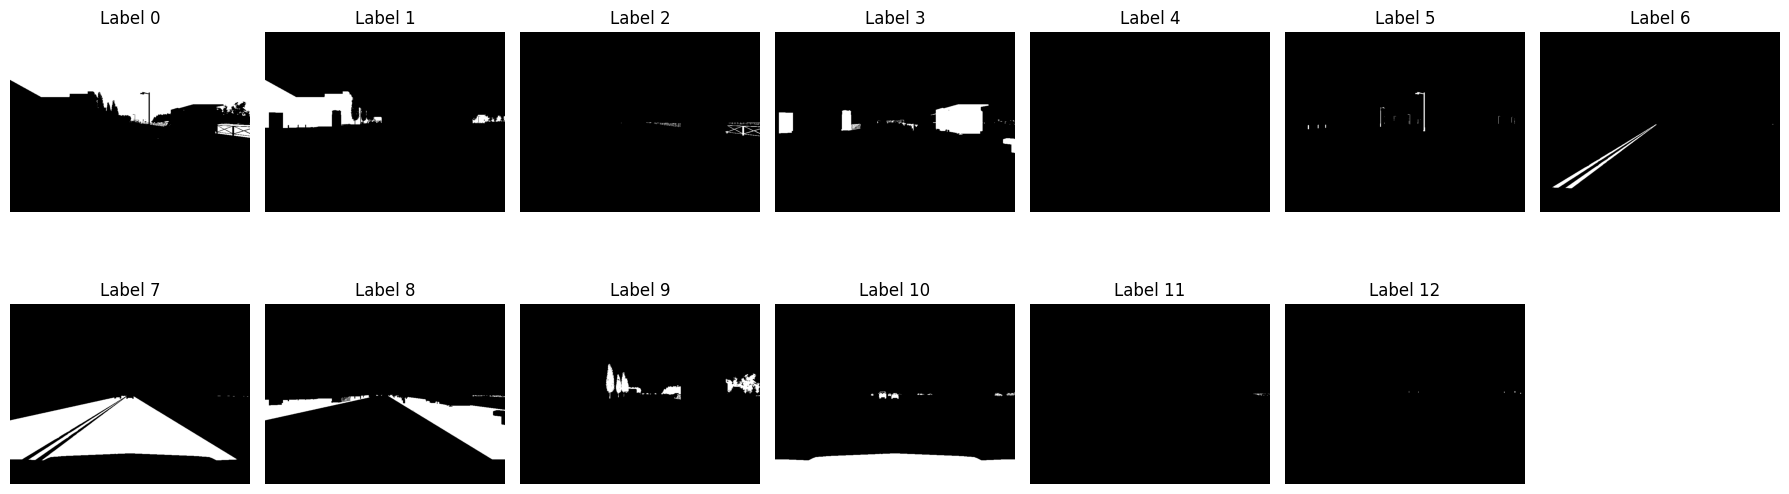

In [ ]:
num_classes = 13
label_ids = list(range(num_classes))
mask_path  = mask_paths[500]
mask = Image.open(mask_path)

mask  = np.array(mask)
mask = mask[:,:,0]
# Hiển thị từng lớp
plt.figure(figsize=(18, 6))
for i in range(num_classes):
    plt.subplot(2, 7, i + 1)
    binary_mask = np.uint8(mask == i)  # sửa lỗi tại đây
    plt.imshow(binary_mask, cmap='gray')
    plt.title(f"Label {i}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
import torchvision.transforms.v2 as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
class CustomDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        # Đọc ảnh
        image = np.array(Image.open(self.image_paths[index]))

        # Đọc mask và lấy kênh đỏ
        mask_rgb = np.array(Image.open(self.mask_paths[index]).convert("RGB"))
        mask = mask_rgb[:, :, 0]



        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mapped_mask = augmented['mask']

        return image, mapped_mask.long()

In [ ]:
#Data augmentation
train_transforms = A.Compose([
    A.RandomScale(scale_limit=(1.0, 2.0), p=1.0),
    A.RandomResizedCrop(size=(512, 512), scale=(0.8, 1.0), ratio=(0.75, 1.333)),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.3),
    A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.3),
    A.GaussianBlur(blur_limit=(3, 5), p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])



val_transforms = A.Compose([
    A.Resize(512,512),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])
#segmentation car and lane
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(image_paths, mask_paths, train_size=0.8, random_state=0)

validation_image_paths, test_image_paths, validation_mask_paths, test_mask_paths = train_test_split(val_image_paths, val_mask_paths, train_size = 0.80, random_state=0)

train_dataset = CustomDataset(train_image_paths, train_mask_paths, transform=train_transforms)
val_dataset = CustomDataset(validation_image_paths, val_mask_paths, transform=val_transforms)
test_dataset = CustomDataset(test_image_paths, test_mask_paths, transform=val_transforms)

In [ ]:
img, mask = train_dataset[0]
print("Unique labels in mask:", torch.unique(mask))

Unique labels in mask: tensor([ 0,  2,  5,  6,  7,  8,  9, 10, 11, 12])


In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,  # Reduce from 8 to 4
    shuffle=True,
    num_workers=2,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32
    ,  # Reduce from 8 to 4
    shuffle=False,
    num_workers=2,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,  # Reduce from 8 to 4
    shuffle=False,
    num_workers=2,
)



In [ ]:
import torch.nn as nn
class ConvBNRelu(nn.Module):
  def __init__(self,in_channels,out_channels,kernel_size = 3, stride=1,padding=1):
    super(ConvBNRelu,self).__init__()
    self.cbr = nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size = kernel_size,stride = stride,padding = padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
  def forward(self,x):
    out = self.cbr(x)
    return out

In [ ]:
class CBAM(nn.Module):
    def __init__(self, channels, reduction_ratio=8):
        super().__init__()
        # Channel Attention
        self.channel_avg = nn.AdaptiveAvgPool2d(1)
        self.channel_max = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction_ratio, 1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction_ratio, channels, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

        # Spatial Attention
        self.spatial_conv = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=5, padding=2, bias=False),  # Giảm kernel size
            nn.BatchNorm2d(1),  # Thêm BN để ổn định
            nn.Sigmoid()
        )

    def forward(self, x):
        # Channel Attention
        avg_out = self.channel_avg(x)
        max_out = self.channel_max(x)
        avg_out = self.fc2(self.relu(self.fc1(avg_out)))
        max_out = self.fc2(self.relu(self.fc1(max_out)))
        channel_att = self.sigmoid(avg_out + max_out)
        x = x * channel_att

        # Spatial Attention
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_in = torch.cat([avg_out, max_out], dim=1)
        spatial_att = self.spatial_conv(spatial_in)
        x = x * spatial_att

        return x

In [ ]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride,
                                   padding=1, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class EdgeHead(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.edge_head = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, 1, 1)
        )

    def forward(self, x):
        return self.edge_head(x)

class AuxHead(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.head = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, num_classes, 1)
        )

    def forward(self, x):
        return self.head(x)

class ConvBNRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class DetailBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.branch = nn.Sequential(
            ConvBNRelu(3, 32, kernel_size=3, stride=2),
            ConvBNRelu(32, 64, kernel_size=3, stride=2),
            nn.Dropout(p=0.5)  # Thêm dropout sau detail branch
        )

    def forward(self, x):
        return self.branch(x)

In [ ]:
class CustomModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        backbone = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1).features

        # Feature stages từ backbone
        self.stage1 = backbone[0]            # [B, 32, H/2, W/2]
        self.stage2 = backbone[1:3]          # [B, 24, H/2, W/2]
        self.stage3 = backbone[3:6]          # [B, 32, H/4, W/4]
        self.stage4 = backbone[6:13]         # [B, 96, H/8, W/8]
        self.stage5 = nn.Sequential(         # [B, 320, H/8, W/8]
            nn.Conv2d(96, 320, kernel_size=1, bias=False),
            nn.BatchNorm2d(320),
            nn.ReLU(inplace=True)
        )

        # Detail branch
        self.detail_branch = DetailBranch()  # Output: [B, 64, H/4, W/4]

        # Reduce dimension
        self.reduce5 = nn.Conv2d(320, 128, kernel_size=1, bias=False)
        self.reduce4 = nn.Conv2d(96, 128, kernel_size=1, bias=False)
        self.reduce3 = nn.Conv2d(32, 64, kernel_size=1, bias=False)
        self.reduce2 = nn.Conv2d(24, 64, kernel_size=1, bias=False)

        # Fusion layers
        self.fuse5_4 = DepthwiseSeparableConv(256, 128)
        self.fuse4_3 = DepthwiseSeparableConv(192, 64)
        self.fuse3_2 = DepthwiseSeparableConv(128, 64)

        # Segmentation and edge heads
        self.seg_head = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),  # Thêm dropout trước đầu ra seg
            nn.Conv2d(64, num_classes, kernel_size=1)
        )
        self.edge_head = EdgeHead(128)

        # Auxiliary head
        self.aux_head = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),  # Thêm dropout trước đầu ra aux
            nn.Conv2d(128, num_classes, 1)
        )

    def forward(self, x):
        rgb = x  # Giữ bản gốc để truyền vào detail branch

        # Backbone
        x1 = self.stage1(x)  # [B, 32, H/2, W/2]
        x2 = self.stage2(x1) # [B, 24, H/2, W/2]
        x3 = self.stage3(x2) # [B, 32, H/4, W/4]
        x4 = self.stage4(x3) # [B, 96, H/8, W/8]
        x5 = self.stage5(x4) # [B, 320, H/8, W/8]

        # Reduce dimensions
        p5 = self.reduce5(x5)  # [B, 128, H/8, W/8]
        p4 = self.reduce4(x4)  # [B, 128, H/8, W/8]

        # Fuse stage5 and stage4
        p4 = self.fuse5_4(torch.cat([p5, p4], dim=1))  # [B, 128, H/8, W/8]
        aux_logits = self.aux_head(p4)

        # Upsample and fuse with stage3
        p4 = F.interpolate(p4, scale_factor=2, mode='bilinear', align_corners=False)  # H/4
        p3 = self.reduce3(x3)  # [B, 64, H/4, W/4]
        p3 = self.fuse4_3(torch.cat([p4, p3], dim=1))  # [B, 64, H/4, W/4]

        # Detail branch
        detail_feat = self.detail_branch(rgb)  # [B, 64, H/4, W/4]

        # Upsample and fuse with stage2
        p3 = F.interpolate(p3, scale_factor=2, mode='bilinear', align_corners=False)  # H/2
        p2 = self.reduce2(x2)  # [B, 64, H/2, W/2]
        p2 = self.fuse3_2(torch.cat([p3, p2], dim=1))  # [B, 64, H/2, W/2]

        # Final fusion with detail
        p2 = F.interpolate(p2, scale_factor=2, mode='bilinear', align_corners=False)  # H/1
        detail_feat = F.interpolate(detail_feat, scale_factor=2, mode='bilinear', align_corners=False)  # [B, 64, H, W]
        final_feat = torch.cat([p2, detail_feat], dim=1)  # [B, 128, H, W]

        # Heads
        seg_out = self.seg_head(final_feat)    # [B, num_classes, H, W]
        edge_out = self.edge_head(final_feat)  # [B, 1, H, W]

        return {
            "seg": seg_out,
            "aux": aux_logits,
            "edge": edge_out
        }

#Loss Function


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
from torchmetrics.classification import MulticlassJaccardIndex
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        # Compute BCE loss without reduction
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        # Compute pt = sigmoid(inputs)
        pt = torch.exp(-BCE_loss)
        # Compute focal loss
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        return F_loss

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        num_classes = logits.shape[1]
        logits = F.softmax(logits, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=num_classes).permute(0, 3, 1, 2).float()

        dims = (0, 2, 3)
        intersection = torch.sum(logits * targets_one_hot, dims)
        cardinality = torch.sum(logits + targets_one_hot, dims)
        dice = (2. * intersection + self.smooth) / (cardinality + self.smooth)
        return 1. - dice.mean()


class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.25):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        pt = torch.where(targets == 1, probs, 1 - probs)
        alpha = torch.where(targets == 1, self.alpha, 1 - self.alpha)
        loss = -alpha * (1 - pt) ** self.gamma * torch.log(pt + 1e-8)
        return loss.mean()


class OHEMLoss(nn.Module):
    def __init__(self, thresh=0.7, min_kept=10000, ignore_index=255):
        super().__init__()
        self.thresh = thresh
        self.min_kept = min_kept
        self.ignore_index = ignore_index
        self.ce_loss = nn.CrossEntropyLoss(reduction='none', ignore_index=ignore_index)

    def forward(self, logits, targets):
        n, c, h, w = logits.size()
        loss = self.ce_loss(logits, targets).view(-1)
        valid_mask = targets.view(-1) != self.ignore_index
        loss = loss[valid_mask]

        if loss.numel() < self.min_kept:
            return loss.mean()
        loss_topk, _ = torch.topk(loss, self.min_kept)
        return loss_topk.mean()


In [ ]:
def generate_edge_mask(mask, ignore_index=255):
    n, h, w = mask.shape
    edge = torch.zeros((n, h, w), device=mask.device, dtype=torch.bool)
    for shift in [(0, 1), (1, 0), (1, 1), (1, -1)]:
        shifted = torch.roll(mask, shifts=shift, dims=(1, 2))
        diff = (mask != shifted) & (mask != ignore_index) & (shifted != ignore_index)
        edge |= diff
    return edge.float()


class SegmentationModel(pl.LightningModule):
    def __init__(self, model: nn.Module, num_classes: int, learning_rate: float = 2e-4,
                 aux_loss_weight: float = 0.4, edge_loss_weight: float = 0.2,
                 accumulation_steps: int = 2):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.aux_loss_weight = aux_loss_weight
        self.edge_loss_weight = edge_loss_weight
        self.accumulation_steps = accumulation_steps
        self.save_hyperparameters(ignore=["model"])

        self.seg_loss_fn = DiceLoss()
        self.aux_loss_fn = OHEMLoss(min_kept=10000, thresh=0.7, ignore_index=255)
        self.edge_loss_fn = FocalLoss()

        self.miou = MulticlassJaccardIndex(num_classes=num_classes, average="macro", ignore_index=255)

    def forward(self, x):
        return self.model(x)

    def shared_step(self, batch, stage):
        images, masks = batch
        masks = masks.squeeze(1) if masks.ndim == 4 else masks

        outputs = self.model(images)
        seg_logits = F.interpolate(outputs["seg"], size=masks.shape[1:], mode="bilinear", align_corners=False)
        aux_logits = F.interpolate(outputs["aux"], size=masks.shape[1:], mode="bilinear", align_corners=False)
        edge_logits = F.interpolate(outputs["edge"], size=masks.shape[1:], mode="bilinear", align_corners=False)

        seg_loss = self.seg_loss_fn(seg_logits, masks)
        aux_loss = self.aux_loss_fn(aux_logits, masks)

        gt_edge = generate_edge_mask(masks)
        edge_loss = self.edge_loss_fn(edge_logits.squeeze(1), gt_edge)

        if self.current_epoch < 10:
            total_loss = seg_loss
        else:
            total_loss = seg_loss + self.aux_loss_weight * aux_loss + self.edge_loss_weight * edge_loss

        self.log(f"{stage}_seg_loss", seg_loss, prog_bar=True, on_epoch=True)
        self.log(f"{stage}_aux_loss", aux_loss, prog_bar=True, on_epoch=True)
        self.log(f"{stage}_edge_loss", edge_loss, prog_bar=True, on_epoch=True)
        self.log(f"{stage}_total_loss", total_loss, prog_bar=True, on_epoch=True)

        preds = torch.argmax(seg_logits, dim=1)
        valid_mask = masks != 255
        if valid_mask.any():
            self.miou.update(preds[valid_mask], masks[valid_mask])

        return total_loss

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "val")

    def on_validation_epoch_end(self):
        miou_score = self.miou.compute()
        self.log("val_mIoU", miou_score, prog_bar=True)
        self.miou.reset()

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")

    def on_test_epoch_end(self):
        miou_score = self.miou.compute()
        self.log("test_mIoU", miou_score, prog_bar=True)
        self.miou.reset()

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=1e-4)
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
                "frequency": 1,
            }
        }


In [ ]:
import torch
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CustomModel(num_classes=13).to(device)

model.eval()

dummy_input = torch.randn(1, 3, 512, 512).to(device)

with torch.no_grad():
    for _ in range(10):
        model(dummy_input)

start_time = time.time()
with torch.no_grad():
    output = model(dummy_input)
end_time = time.time()

elapsed_time = end_time - start_time
fps = 1 / elapsed_time if elapsed_time > 0 else float('inf')


print(f"Model output shape: {output['seg'].shape}")
print(f"Time for one inference: {elapsed_time:.4f} seconds")
print(f"FPS: {fps:.2f}")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 53.0MB/s]


Model output shape: torch.Size([1, 13, 256, 256])
Time for one inference: 1.5924 seconds
FPS: 0.63


In [ ]:
for images, masks in train_loader:
    if masks.dim() == 4:
        masks = masks.squeeze(1)
    labels, counts = torch.unique(masks, return_counts=True)
    for label, count in zip(labels.tolist(), counts.tolist()):
        print(f"Label {label}: {count} pixels")
    break


Label 0: 2657849 pixels
Label 1: 690093 pixels
Label 2: 132897 pixels
Label 3: 72058 pixels
Label 4: 1059 pixels
Label 5: 31445 pixels
Label 6: 60566 pixels
Label 7: 1778916 pixels
Label 8: 606724 pixels
Label 9: 1068222 pixels
Label 10: 1255203 pixels
Label 11: 27079 pixels
Label 12: 6497 pixels


In [ ]:
custom = CustomModel(num_classes=13)
model = SegmentationModel(model=custom,num_classes=13)


# Train

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_mIoU',
    dirpath='/content/drive/MyDrive/auto car kaggle/checkpoints',
    mode='max',
    save_top_k=1,
    filename='best-checkpoint',
    save_last=True,
    verbose = True
)

early_stopping_callback = EarlyStopping(
    monitor='val_mIoU',
    patience=10,
    mode='max'
)

trainer = Trainer(
    max_epochs=150,
    callbacks=[checkpoint_callback, early_stopping_callback],
    accelerator="auto",
    devices="auto",
    precision=16,
    default_root_dir = '/content/drive/MyDrive/auto car kaggle/lightning_logs'
)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)


# Evaluation

In [ ]:
custom = CustomModel(num_classes=13)
model = SegmentationModel(model=custom,num_classes=13)


In [ ]:
checkpoint_path = "/content/drive/MyDrive/auto car kaggle/checkpoints/best-checkpoint.ckpt"
model = SegmentationModel.load_from_checkpoint(
    checkpoint_path,
    model=CustomModel(num_classes=13),  
    num_classes=13,
    learning_rate=2e-4,

)

trainer = pl.Trainer(accelerator="gpu" if torch.cuda.is_available() else "cpu", devices=1)

trainer.test(model, dataloaders=test_loader)

INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_aux_loss       │    2.2453951835632324     │
│      test_edge_loss       │   0.011987278237938881    │
│         test_mIoU         │     0.765670895576477     │
│       test_seg_loss       │    0.17131321132183075    │
│      test_total_loss      │    0.17131321132183075    │
└───────────────────────────┴───────────────────────────┘

[{'test_seg_loss': 0.17131321132183075,
  'test_aux_loss': 2.2453951835632324,
  'test_edge_loss': 0.011987278237938881,
  'test_total_loss': 0.17131321132183075,
  'test_mIoU': 0.765670895576477}]

# Test

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 87.8MB/s]



--- Sample 1 ---
GT mask classes: [ 0  1  2  3  5  6  7  8  9 10 11 12]
Pred mask classes: [ 0  1  5  7  8  9 10 11]


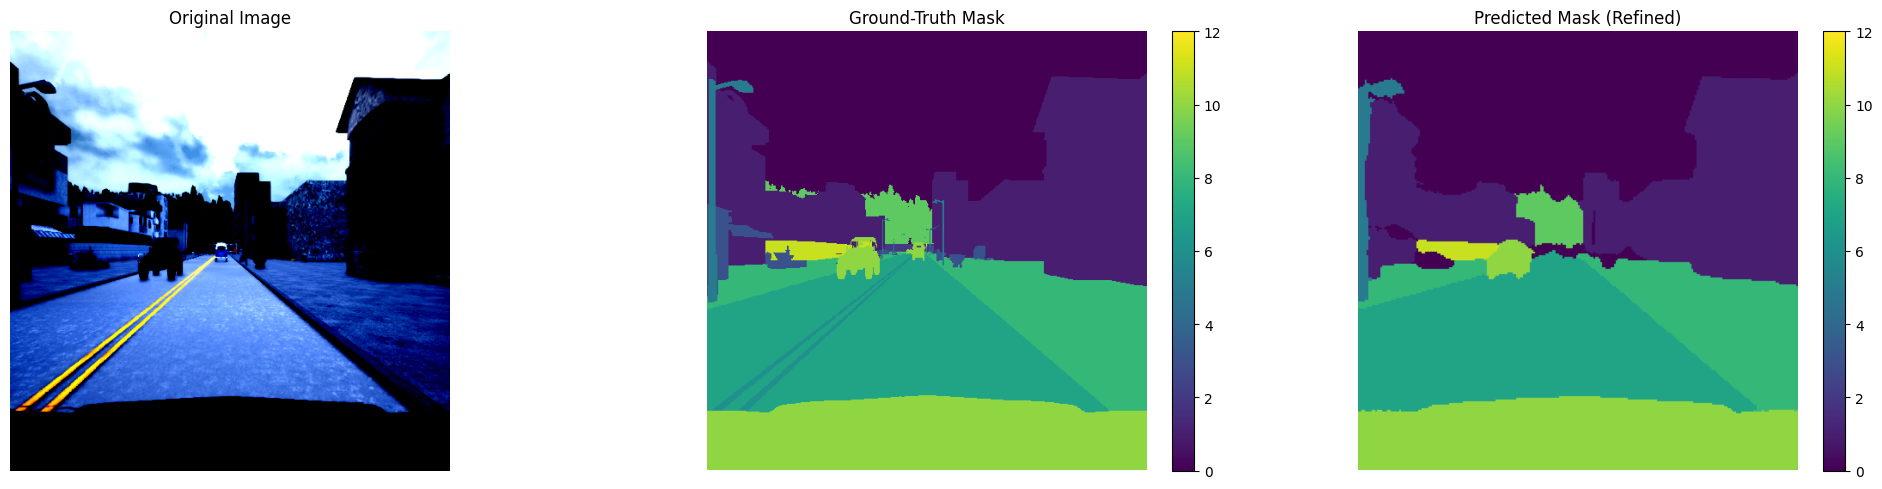


--- Sample 2 ---
GT mask classes: [ 0  2  5  6  7  8  9 10 12]
Pred mask classes: [ 0  2  7  8  9 10]


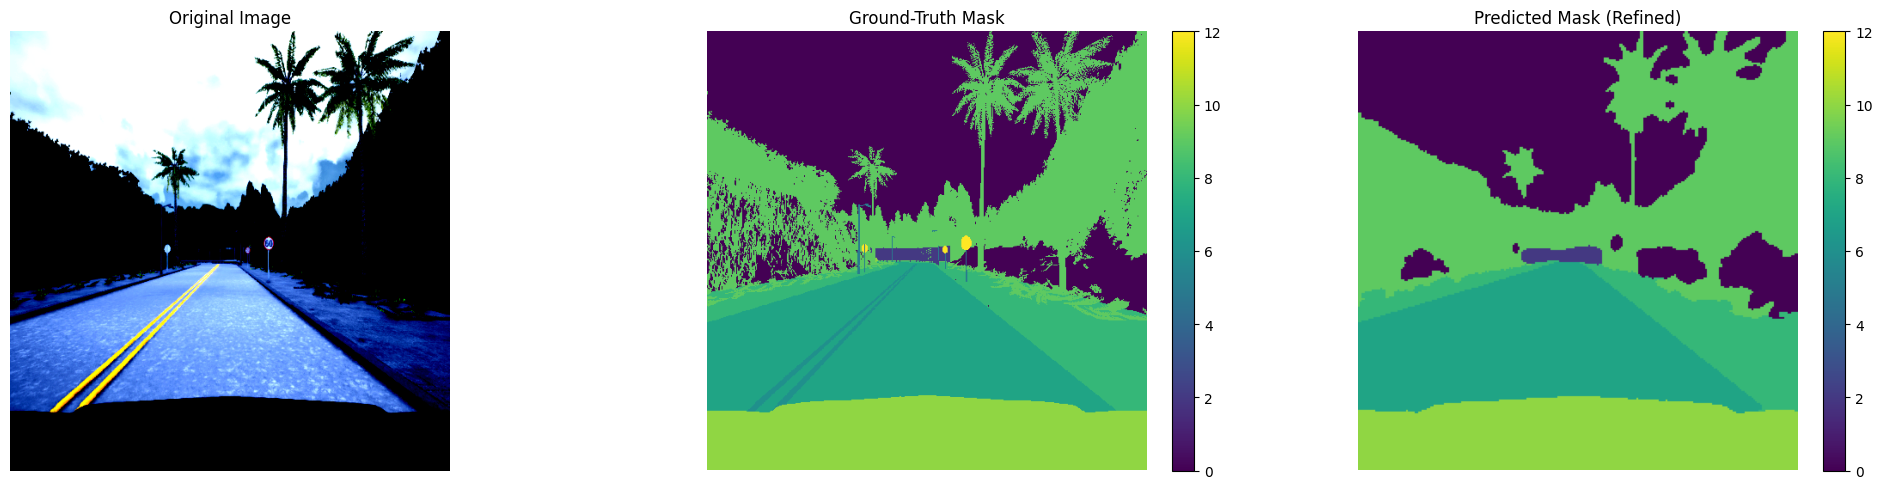


--- Sample 3 ---
GT mask classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Pred mask classes: [ 0  1  2  3  5  7  8  9 10]


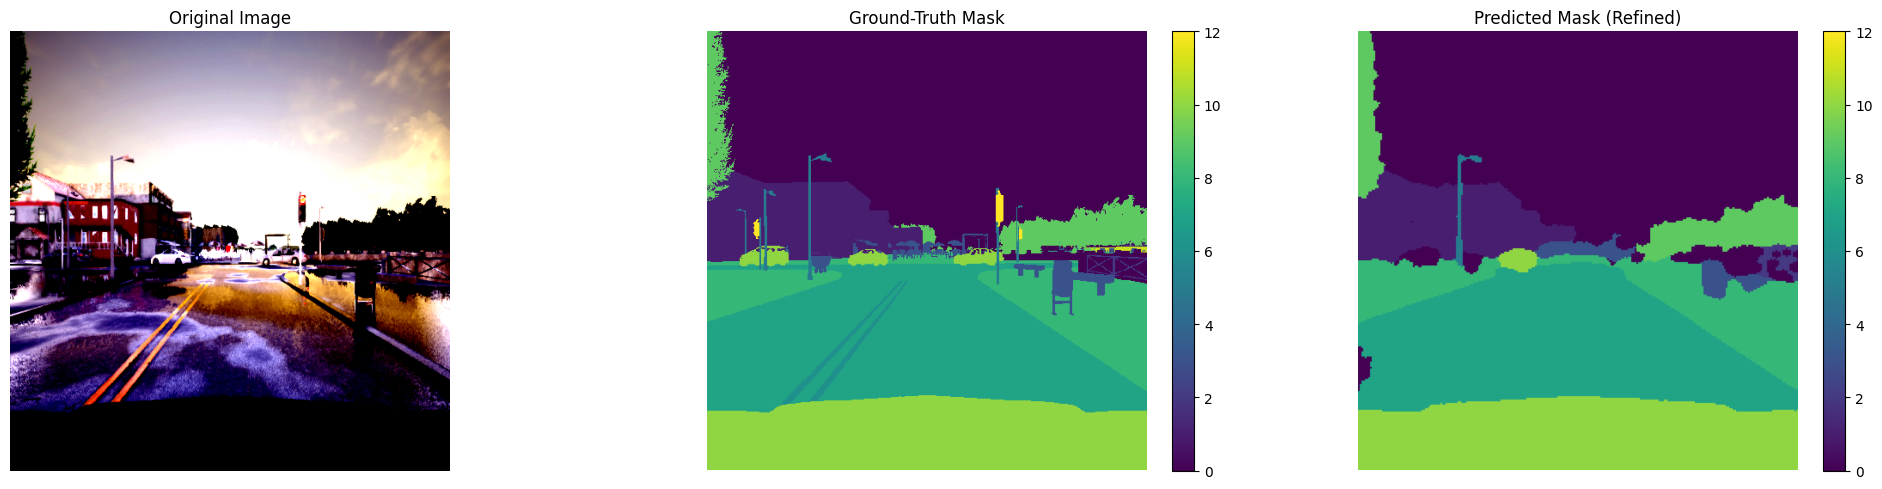


--- Sample 4 ---
GT mask classes: [ 0  1  2  3  5  6  7  8  9 10 11 12]
Pred mask classes: [ 0  1  2  3  7  8  9 10]


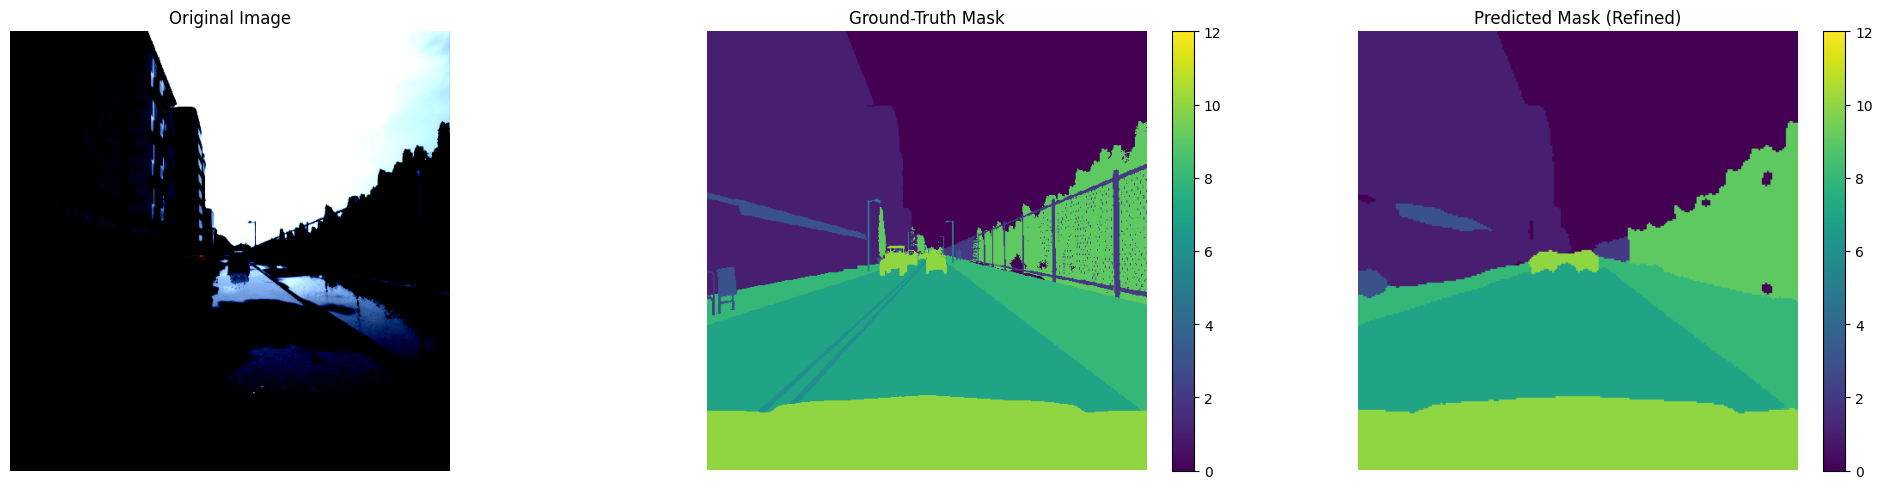


--- Sample 5 ---
GT mask classes: [ 0  2  3  5  6  7  8  9 10 12]
Pred mask classes: [ 0  2  7  8  9 10]


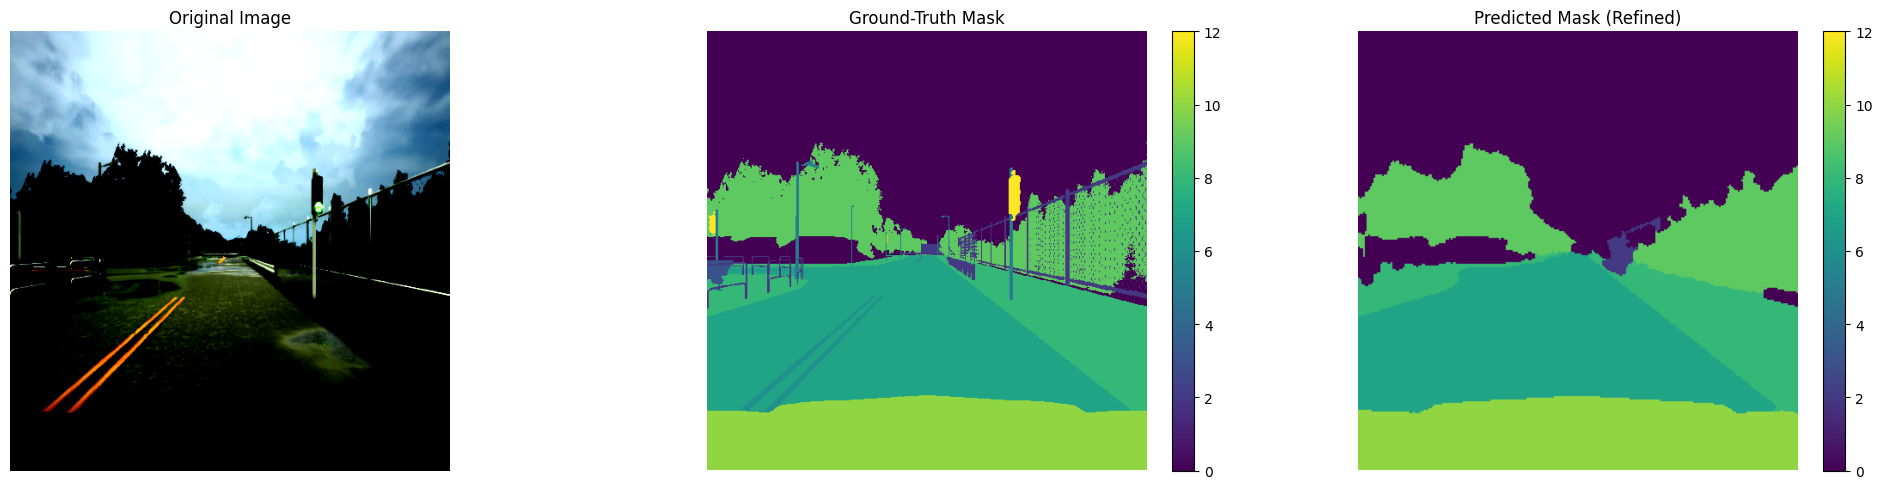


--- Sample 6 ---
GT mask classes: [ 0  1  2  3  5  6  7  8  9 10 12]
Pred mask classes: [ 0  1  2  3  7  8  9 10]


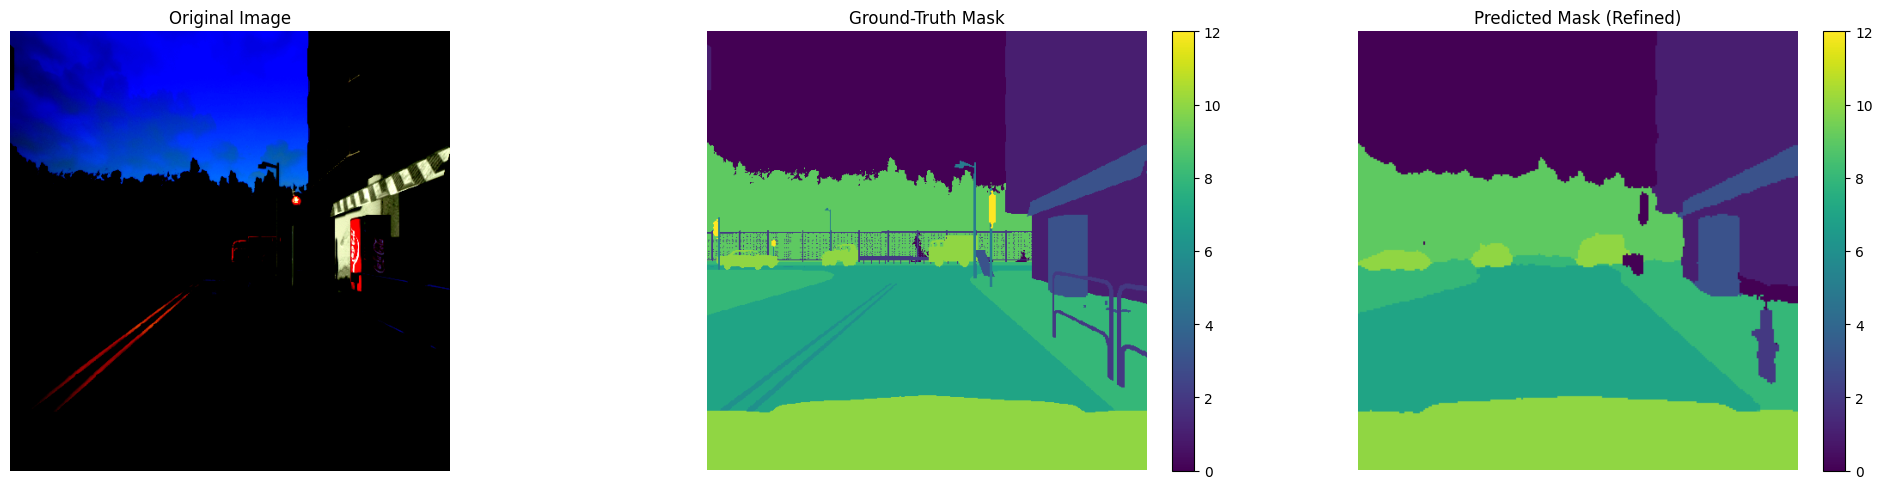


--- Sample 7 ---
GT mask classes: [ 0  1  2  3  5  6  7  8  9 10 11 12]
Pred mask classes: [ 0  1  2  3  7  8  9 10 11]


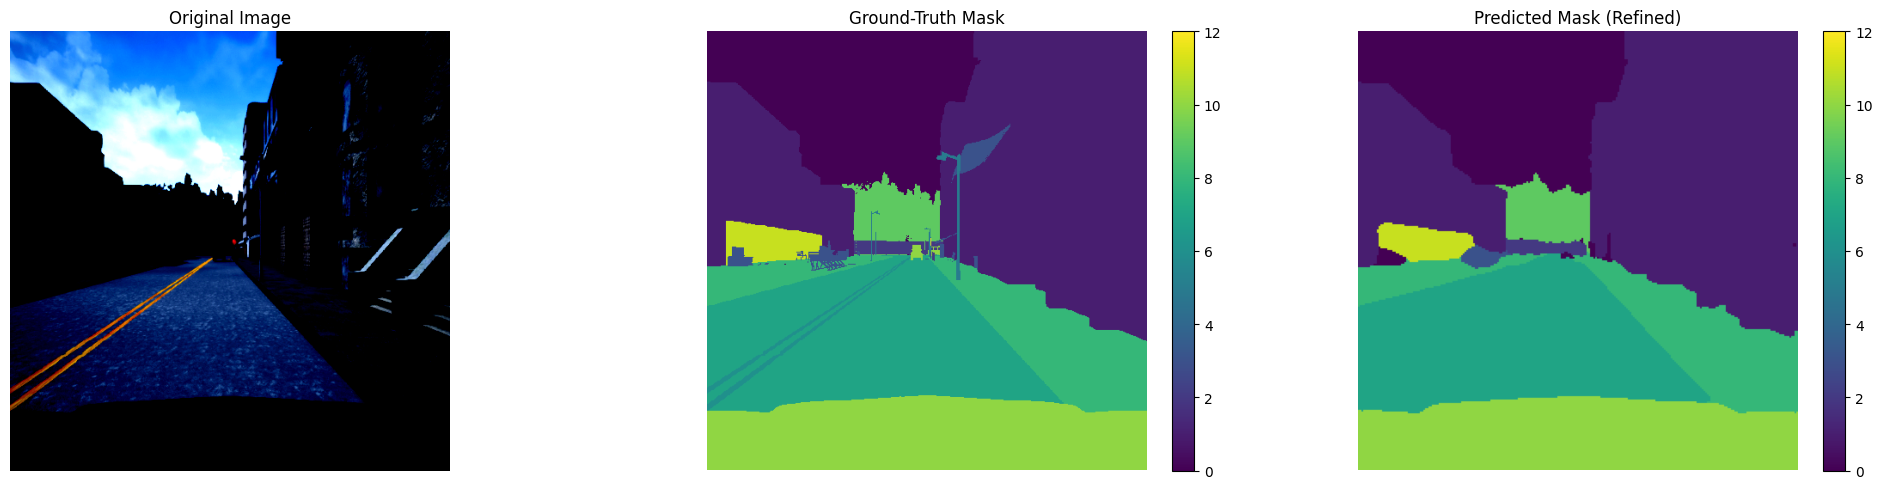


--- Sample 8 ---
GT mask classes: [ 0  1  2  3  5  6  7  8  9 10 11 12]
Pred mask classes: [ 0  1  2  3  7  8  9 10]


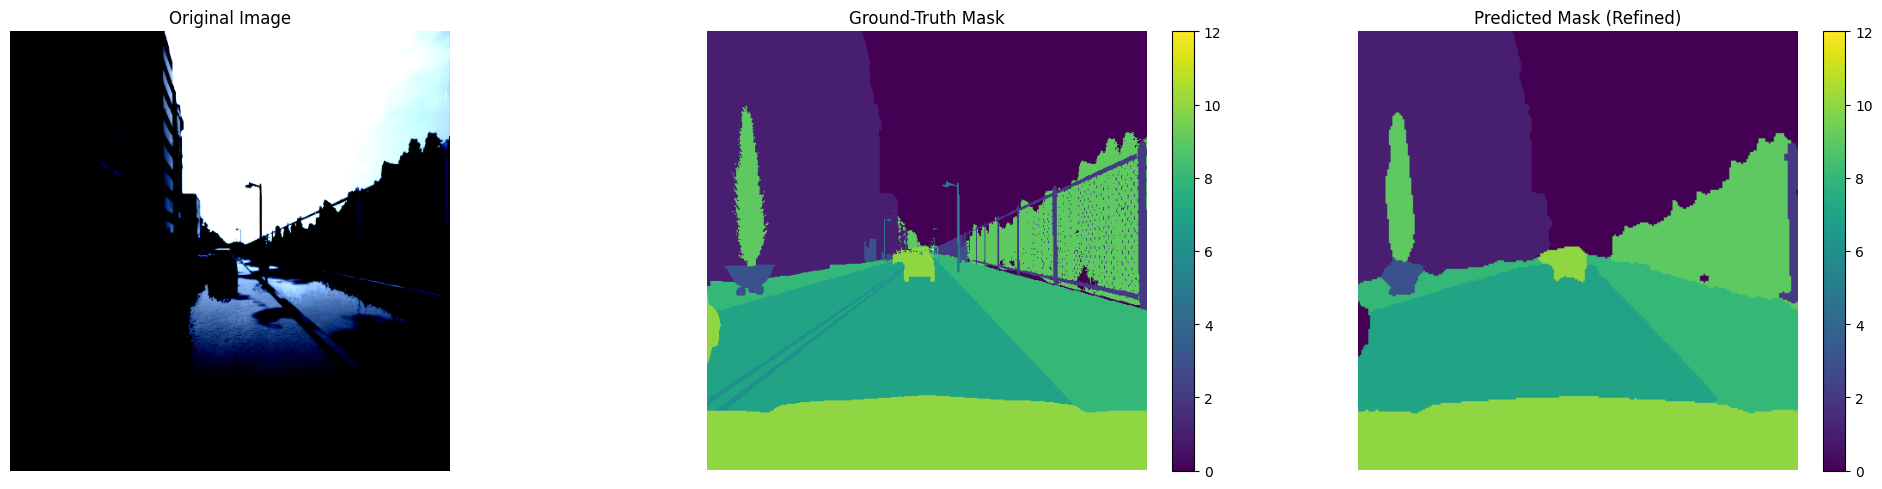


--- Sample 9 ---
GT mask classes: [ 0  1  2  3  5  6  7  8  9 10 11 12]
Pred mask classes: [ 0  1  5  7  8  9 10]


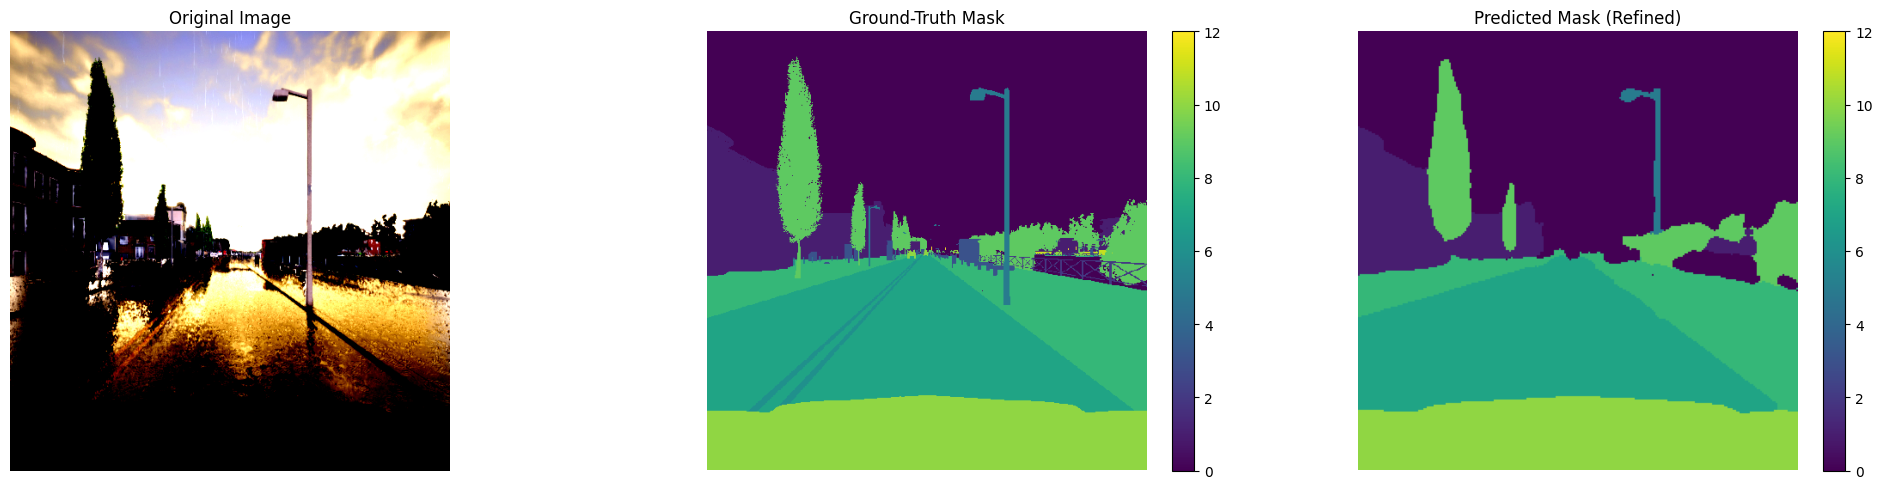


--- Sample 10 ---
GT mask classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Pred mask classes: [ 0  1  7  8  9 10 11]


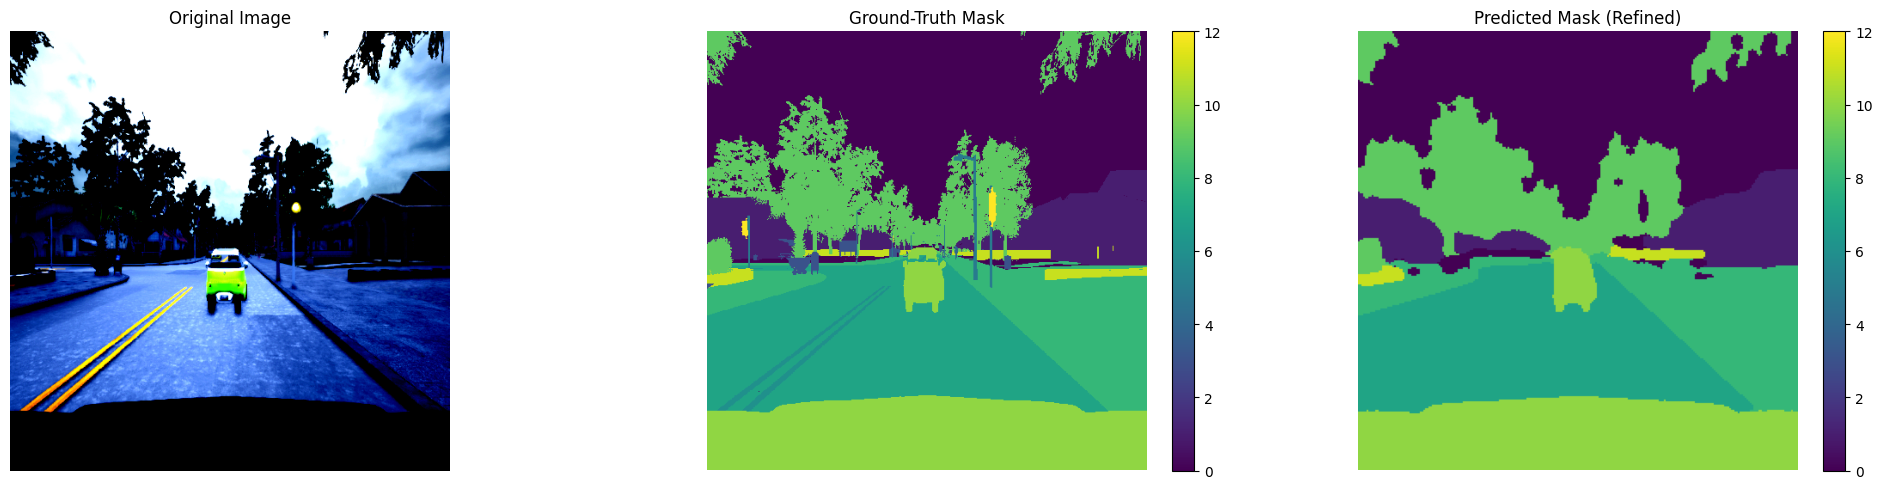

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

def remove_small_regions(mask, min_size=200):
    for label in np.unique(mask):
        mask_label = (mask == label).astype(np.uint8)
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_label)
        for i in range(1, num_labels):
            if stats[i, cv2.CC_STAT_AREA] < min_size:
                mask[labels == i] = 0
    return mask

def refine_mask(mask, ignore_mask=None):
    if ignore_mask is not None:
        original_mask = mask.copy()
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        closed = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
        cleaned = remove_small_regions(closed, min_size=200)
        # Khôi phục các pixel ignore về giá trị ban đầu
        cleaned[ignore_mask] = original_mask[ignore_mask]
        return cleaned
    else:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        closed = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
        return remove_small_regions(closed, min_size=200)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 13 
model = CustomModel(num_classes=num_classes)
model.to(device)

ckpt_path = "/content/drive/MyDrive/auto car kaggle/checkpoints/best-checkpoint.ckpt"
ckpt = torch.load(ckpt_path, map_location=device)
state_dict = {k.replace("model.", ""): v for k, v in ckpt['state_dict'].items()}
model.load_state_dict(state_dict,strict=False)
model.eval()

num_samples = 10
count = 0
num_classes = 13

plt.get_cmap('tab20', num_classes)

with torch.no_grad():
    for batch in test_loader:
        images = batch[0].to(device)
        gt_masks = batch[1].cpu().numpy()

        if gt_masks.ndim == 4:
            gt_masks = gt_masks[:, 0]

        outputs = model(images)

        seg_outputs = outputs['seg']

        pred_masks = torch.argmax(seg_outputs, dim=1).cpu().numpy()

        for j in range(pred_masks.shape[0]):
            pred_masks[j] = refine_mask(pred_masks[j])


        original_images = images.cpu().permute(0, 2, 3, 1).numpy().clip(0, 1)

        for i in range(images.size(0)):
            if count >= num_samples:
                break

            image_np = (original_images[i] * 255).astype(np.uint8)
            if image_np.shape[2] == 1:
                image_np = np.repeat(image_np, 3, axis=2)
            image_pil = Image.fromarray(image_np)

            print(f"\n--- Sample {count + 1} ---")
            print("GT mask classes:", np.unique(gt_masks[i]))
            print("Pred mask classes:", np.unique(pred_masks[i]))

            plt.figure(figsize=(20, 5))

            plt.subplot(1, 3, 1)
            plt.imshow(image_pil)
            plt.title("Original Image")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            im2 = plt.imshow(gt_masks[i], vmin=0, vmax=num_classes - 1)
            plt.title("Ground-Truth Mask")
            plt.axis("off")
            plt.colorbar(im2, fraction=0.046, pad=0.04)

            plt.subplot(1, 3, 3)
            im3 = plt.imshow(pred_masks[i], vmin=0, vmax=num_classes - 1)
            plt.title("Predicted Mask (Refined)")
            plt.axis("off")
            plt.colorbar(im3, fraction=0.046, pad=0.04)



            plt.tight_layout()
            plt.show()

            count += 1

        if count >= num_samples:
            break
